In [56]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, train_test_split

import kagglehub
from xgboost import XGBRegressor



In [ ]:
# Download latest version
path = kagglehub.dataset_download("denkuznetz/food-delivery-time-prediction")

print("Path to dataset files:", path)

In [41]:
data = pd.read_csv(f"{path}\Food_Delivery_Times.csv")
data.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [42]:
data.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


# Initial thoughts
- Immediately we see that the Order ID feature is redundant. It has no correlation with delivery time.
- Distance will obviously have a correlation with delivery time.
- Time of day most likely does have an effect: traffic will vary at different times of day.
- Preparation time is obviously correlated; the longer it takes to prepare the order, the longer it will take to deliver.
- Courier experience: this is not so obvious. One might think a courier with more experience would lead to lower times but this is not reliably the case.
- Traffic level: intuitively busier traffic means longer delivery times.
- Weather: bad weather probably leads to higher delivery times.
- Vehicle type: cars are likely to take longer (they may need parking and are more affected by traffic)

In [43]:
# Drop redundant columns
data.drop(['Order_ID'], axis=1, inplace=True)


In [44]:
missing_vals = data.isnull().sum()
missing_vals

Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

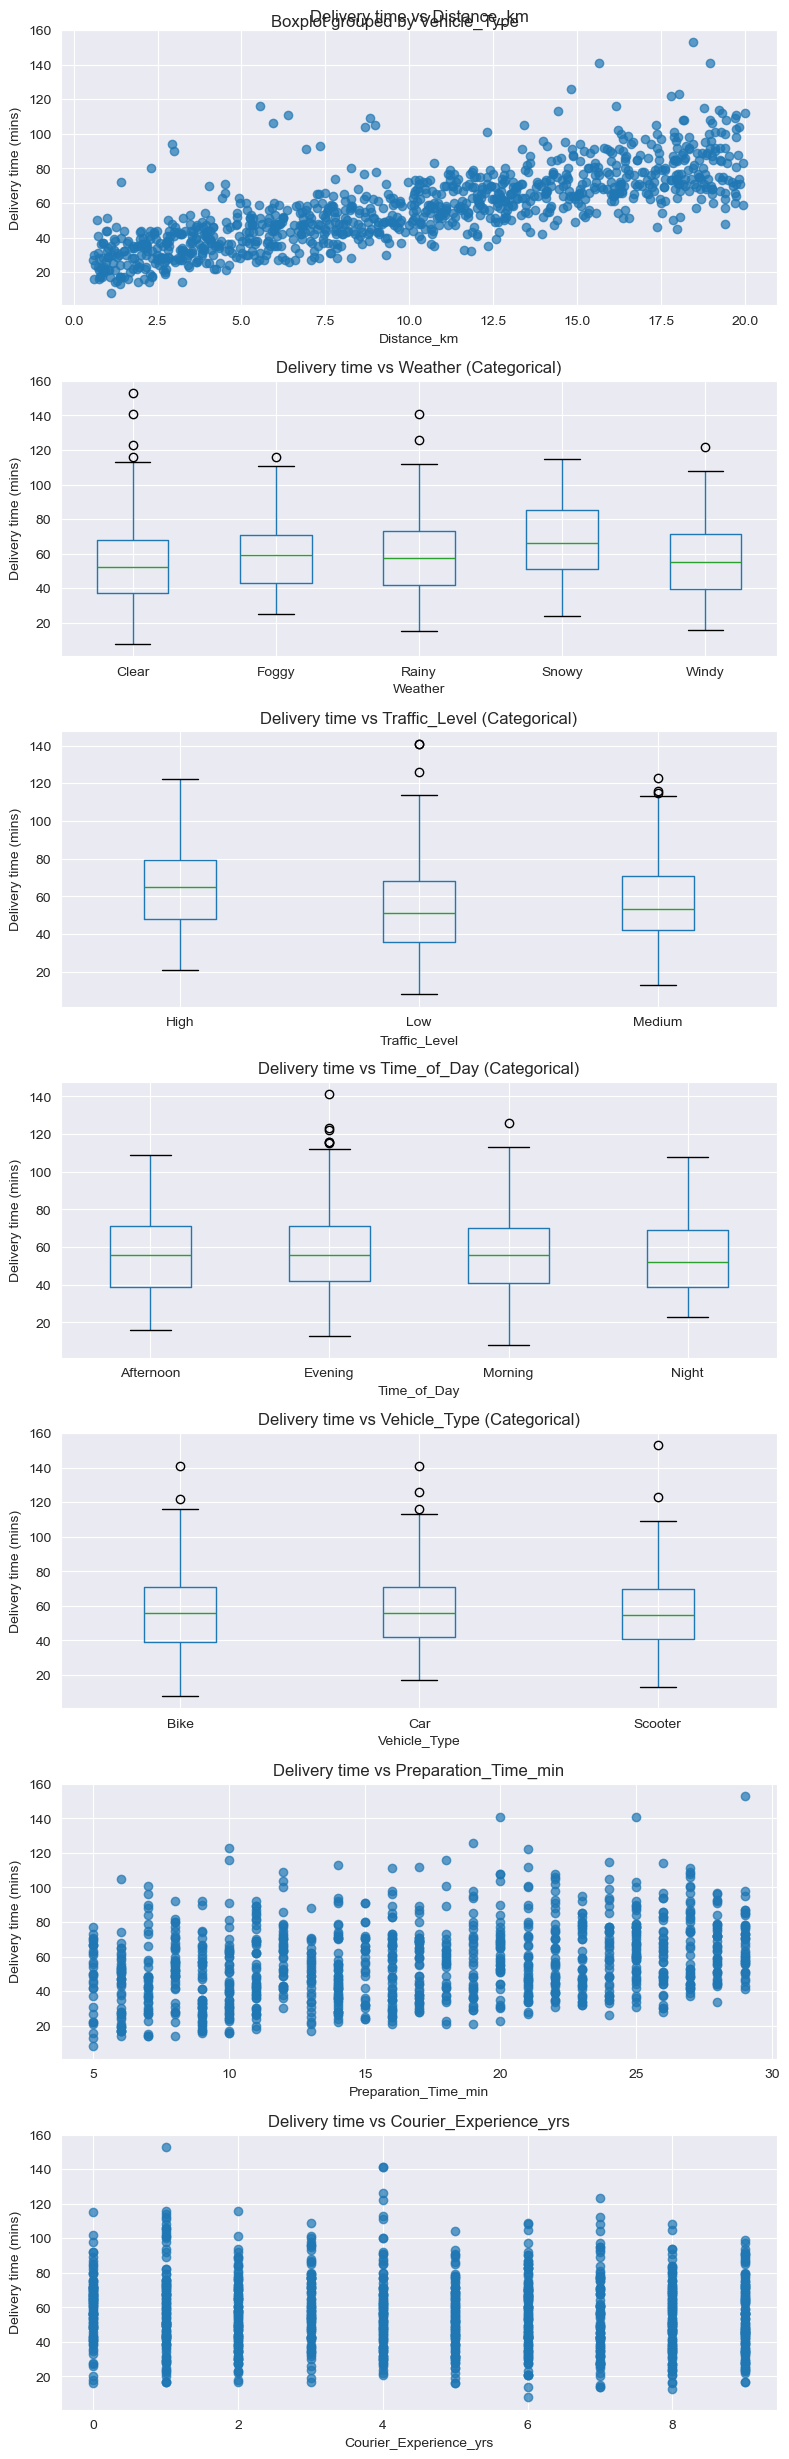

In [45]:
# Visualising variable correlations
fig, axes = plt.subplots(len(data.columns)-1, 1, figsize=(8, 25))

for i, (col, ax) in enumerate(zip(data.columns[:-1], axes)):
    if data[col].dtype == 'object' or len(data[col].unique()) < 10:
        # Categorical variable: boxplot
        data.boxplot(column='Delivery_Time_min', by=col, ax=ax)
        ax.set_title(f"Delivery time vs {col} (Categorical)")
        ax.set_xlabel(col)
        ax.set_ylabel('Delivery time (mins)')
    else:
        # Numerical variable: scatter plot
        ax.scatter(data[col], data['Delivery_Time_min'], alpha=0.7)
        ax.set_title(f"Delivery time vs {col}")
        ax.set_xlabel(col)
        ax.set_ylabel('Delivery time (mins)')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [49]:
data[['Courier_Experience_yrs', 'Preparation_Time_min', 'Delivery_Time_min']].corr()



,Courier_Experience_yrs,Preparation_Time_min,Delivery_Time_min
Courier_Experience_yrs,1.000000,-0.03083,-0.090433
Preparation_Time_min,-0.030830,1.00000,0.307350
Delivery_Time_min,-0.090433,0.30735,1.000000


Very weak correlation between courier experience and delivery times, so we can drop this feature.

In [38]:
data.drop(['Courier_Experience_yrs'], axis=1, inplace=True)

In [ ]:
# Encoding categorical variables

In [53]:
# Splitting data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

# Simple XGBoost model using two features to predict delivery time
X_train = train_data[['Distance_km', 'Preparation_Time_min']]
y_train = train_data[['Delivery_Time_min']]

X_test = test_data[['Distance_km', 'Preparation_Time_min']]
y_test = test_data[['Delivery_Time_min']]

In [88]:
xgb_model = XGBRegressor(base_score=None, booster=None, callbacks=[], colsample_bylevel=1.0,
             colsample_bynode=None, colsample_bytree=0.7484902995707594,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.2940772531134296,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=6,
             min_child_weight=87.59904478536464,
             monotone_constraints=None, multi_strategy=None, n_estimators=64,
             n_jobs=-1, num_parallel_tree=None, random_state=None)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=[], colsample_bylevel=1.0,
             colsample_bynode=None, colsample_bytree=0.7484902995707594,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.2940772531134296,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=6,
             min_child_weight=87.59904478536464, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=64,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [94]:
y_pred = xgb_model.predict(X_test)


In [101]:
y_pred = np.expand_dims(y_pred, axis=1)

In [95]:
def error_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = sp.stats.pearsonr(y_true, y_pred)[0]**2
    return mae, rmse, r2


In [104]:
mae, rmse, r2 = error_metrics(y_test, y_pred)
print(mae, rmse, r2)

8.072482070922852 11.50640683834471 [0.73297015]


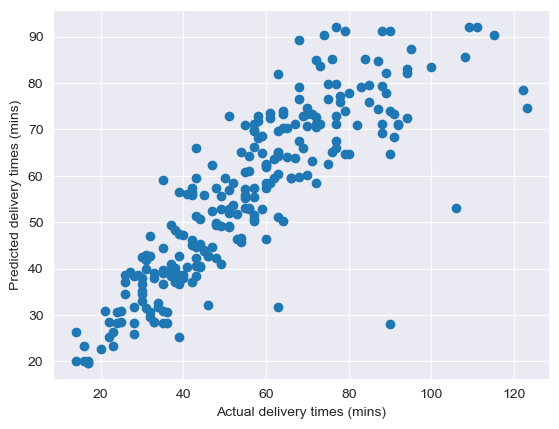

In [107]:
# Plotting predictions against test values
plt.plot(y_test, y_pred, 'o')
plt.xlabel("Actual delivery times (mins)")
plt.ylabel("Predicted delivery times (mins)")
plt.show()

A simple model with only two features performs decently well. We want a higher R2 score though as this indicates the model's ability to predict the delivery time.

This time we'll try to include categorical features too. We need to encode them so we can try the following:
- Target encoding
-